# Finance Project


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime,timedelta,date
import time
import talib as tb

[*********************100%%**********************]  1 of 1 completed


C:\Users\nikhi\AppData\Roaming\Python\Python310\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


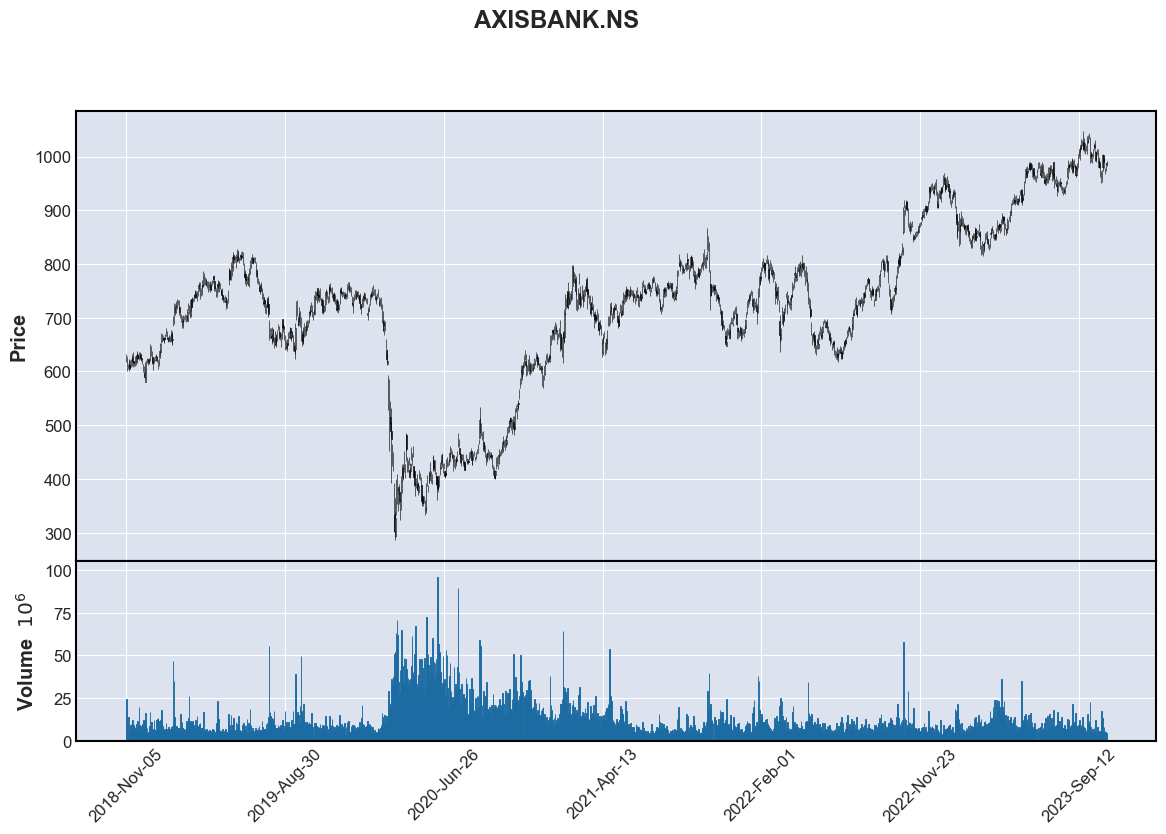

In [2]:
stock="AXISBANK.NS"
days=365*5
start_date=date.today()-timedelta(days=days)
end_date=date.today()-timedelta(days=0)

stock_data = yf.download(stock, start_date , end_date, interval="1d")
stock_data = stock_data.drop('Adj Close', axis=1)


fig, axes = mpf.plot(stock_data, type='candle',volume=True, figsize=(15, 9), returnfig=True,title=stock)
plt.show()

C:\Users\nikhi\AppData\Roaming\Python\Python310\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


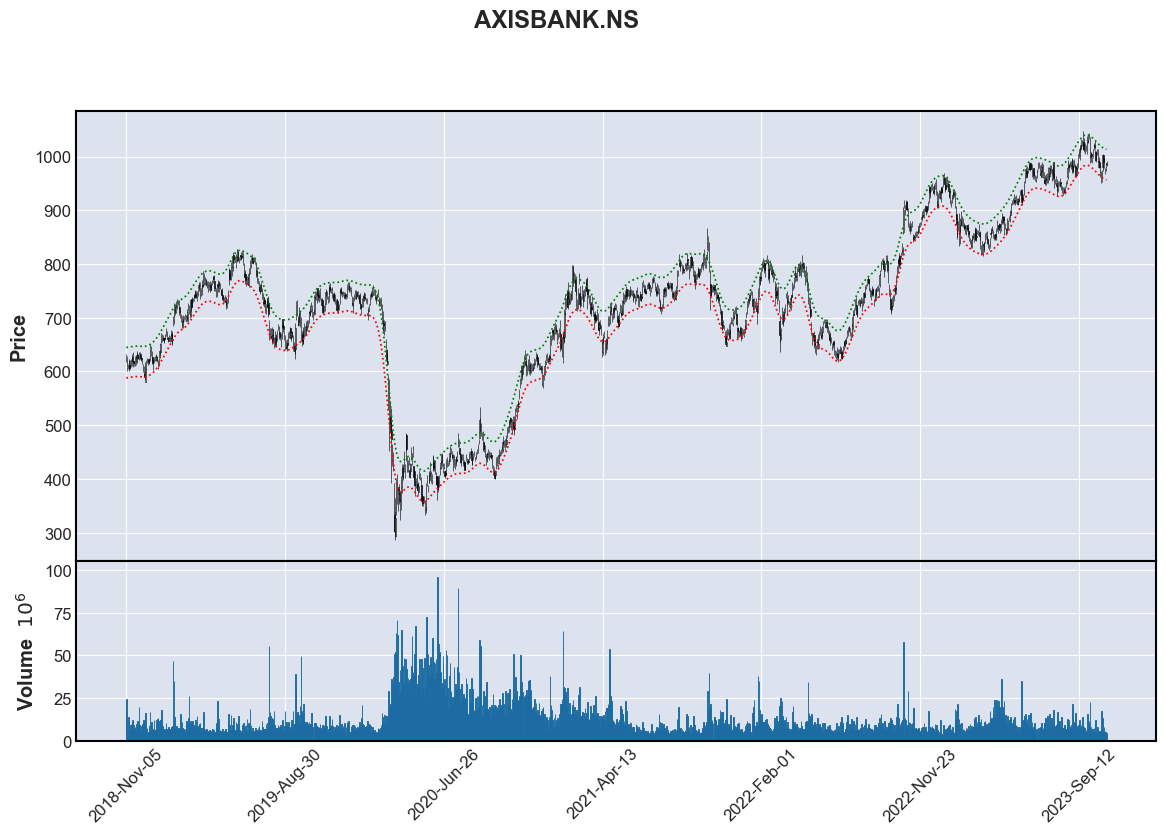

C:\Users\nikhi\AppData\Local\Temp\ipykernel_6648\2391057952.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["ATR"].iloc[0:14] = stock_data["ATR"].iloc[14]


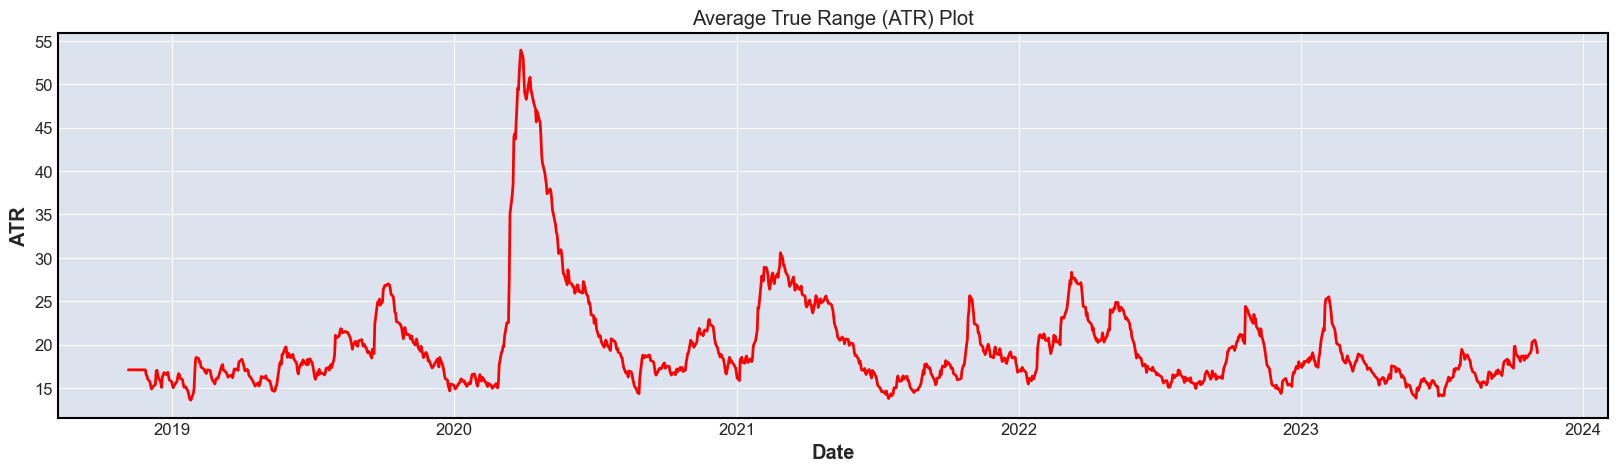

In [3]:
def gaussian_kernel(x, xi, h):
    return norm.pdf(x,xi,h)
def mean_absolute_error(close, smoothed):
    return np.mean(np.abs(close - smoothed))
smoothed_close = []
bandwidth=8
for i in range(len(stock_data)):
    xi = stock_data['Close'].iloc[i]
    weights =[]
    weighted_sum =[]
    for j in range(len(stock_data)):
        xj=stock_data["Close"].iloc[j]
        w=gaussian_kernel(j,i,bandwidth)
        sumw=xj*w
        weights.append(w)
        weighted_sum.append(sumw)

    # print(weights)
    # print(weighted_sum)
    if sum(weights)!=0:
        weighted_sum/=sum(weights)
    smoothed_close.append(sum(weighted_sum))

# Add the smoothed close to the DataFrame
stock_data['smoothed close repainted'] = smoothed_close
multi = 2
width = []
for i in range(len(stock_data)):
    xi = stock_data['smoothed close repainted'].iloc[i]
    mae = mean_absolute_error(stock_data["Close"],stock_data['smoothed close repainted'] )
    
stock_data['width'] = mae*multi

stock_data["upper band"]=stock_data["smoothed close repainted"]+stock_data["width"]
stock_data["lower band"]=stock_data["smoothed close repainted"]-stock_data["width"]

lower_bound=mpf.make_addplot(stock_data["lower band"], ylabel="Lower Band", color="red",linestyle="dotted")
upper_bound= mpf.make_addplot(stock_data["upper band"], ylabel="Upper Band", color="green",linestyle="dotted")

fig, axes = mpf.plot(stock_data, type='candle',addplot=[lower_bound,upper_bound],volume=True, figsize=(15, 9), returnfig=True,title=stock)
plt.show()

# using talib library to use ATR(Average true range) function
stock_data['ATR'] = tb.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data["ATR"].iloc[0:14] = stock_data["ATR"].iloc[14]

# Set the figure size
plt.figure(figsize=(20, 5))
plt.plot(stock_data["ATR"], color="red")
plt.xlabel("Date")
plt.ylabel("ATR")
plt.title("Average True Range (ATR) Plot")
plt.grid(True)
plt.show()



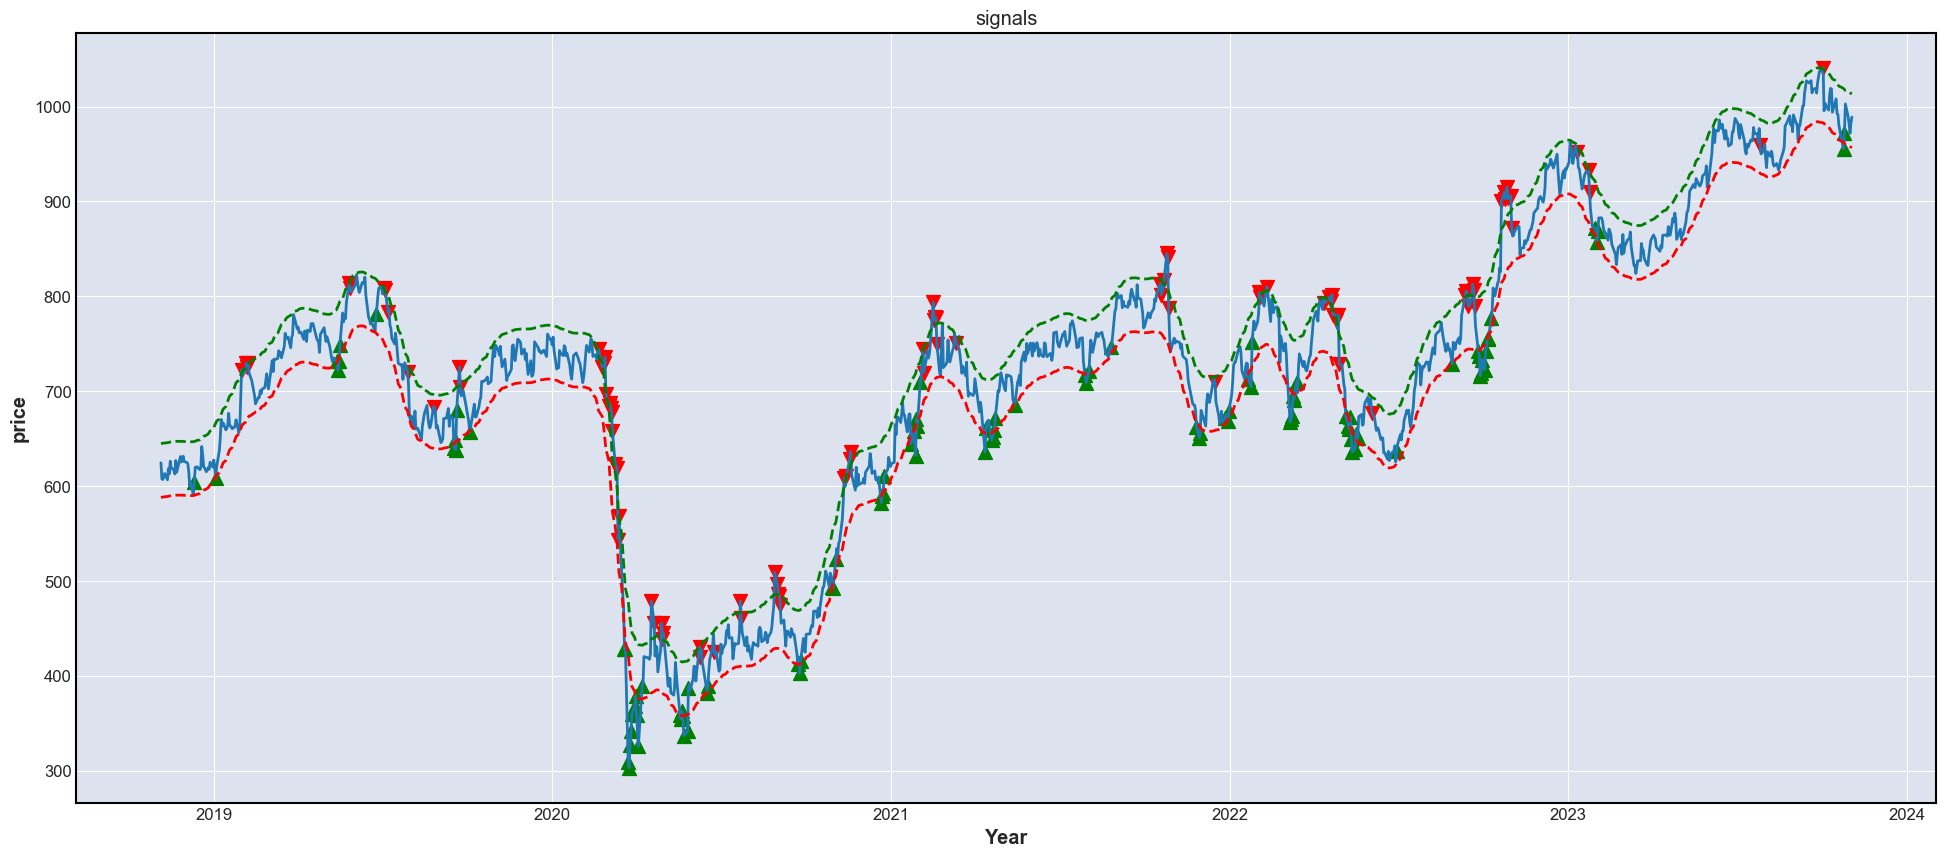

In [4]:
# signal
stock_data["signal"] = 0
stock_data.loc[(stock_data['Open'] >= stock_data['upper band']) | (stock_data['Close'] >= stock_data['upper band']), 'signal'] = -1
stock_data.loc[(stock_data['Open'] <= stock_data['lower band']) | (stock_data['Close'] <= stock_data['lower band']), 'signal'] = 1

plt.figure(figsize=(24, 10))
plt.plot(stock_data.index, stock_data["Close"], label="Close Price")
plt.plot(stock_data.index,stock_data["lower band"], color= 'red', linestyle='dashed', linewidth=2, markersize=15) 
plt.plot(stock_data.index,stock_data["upper band"], color= 'green', linestyle='dashed', linewidth=2, markersize=15) 
# Plot entry positions as green triangles and exit positions as red triangles for long trades
plt.scatter(x=stock_data[stock_data["signal"]==1].index,y=stock_data['Close'][stock_data["signal"]==1], color='g', s=100, marker='^', label='Long')
plt.scatter(x=stock_data[stock_data["signal"]==-1].index,y=stock_data["Close"][stock_data["signal"]==-1], color='r',s = 100, marker='v', label='short')
plt.title("signals")
plt.xlabel("Year")
plt.ylabel("price")
plt.show()

# Trade excution
1. take trade when we get signal
2. if i get another same signal in the direction of trade ignore the signal
3. if i get signal in different directions the exit that trade and take an entry from there


In [5]:
# trade excution

stock_entries=[]
stock_exits=[]
stock_trade=[]
risk_reward_ratio=4
trade=0
i=0
while (i<len(stock_data)):
    if(stock_data["signal"].iloc[i]==1):
        # print("long trade started",i)
        trade=1
        stock_trade.append(trade)
        entry=stock_data["Close"].iloc[i]
        stock_entries.append(entry)
        stoploss=entry-stock_data["ATR"].iloc[i]
        target=entry+(risk_reward_ratio*stock_data["ATR"].iloc[i])
        for j in range(i+1,len(stock_data)):
            if(stock_data["signal"].iloc[j]==-1):     
                exit=stock_data["Close"].iloc[j]
                stock_exits.append(exit)
                break
            
            elif(stock_data["signal"].iloc[j]==0 and stock_data["High"].iloc[j]>=target):
                exit=target
                stock_exits.append(exit)
                break

            elif(stock_data["signal"].iloc[j]==0 and (stock_data["Close"].iloc[j]<=stoploss or stock_data["Open"].iloc[j]<=stoploss)):
                exit=stoploss
                stock_exits.append(exit)
                break
            elif(stock_data["signal"].iloc[j]==0 and j==len(stock_data)-1):
                exit=stock_data["Close"].iloc[j]
                stock_exits.append(exit)
                break
        # print("long trade done",j)
        i=j
           

    if(stock_data["signal"].iloc[i]==-1):
        # print("short trade started",i) 
        trade=-1
        stock_trade.append(trade)
        entry=stock_data["Close"].iloc[i]
        stock_entries.append(entry)
        stoploss=entry+stock_data["ATR"].iloc[i]
        target=entry-(risk_reward_ratio*stock_data["ATR"].iloc[i])
        for j in range(i+1,len(stock_data)):
            if(stock_data["signal"].iloc[j]==1):     
                exit=stock_data["Close"].iloc[j]
                stock_exits.append(exit)
                break
            
            elif(stock_data["signal"].iloc[j]==0 and stock_data["High"].iloc[j]<=target):
                exit=target
                stock_exits.append(exit)
                break

            elif(stock_data["signal"].iloc[j]==0 and (stock_data["Close"].iloc[j]>=stoploss or stock_data["Open"].iloc[j]>=stoploss)):
                exit=stoploss
                stock_exits.append(exit)
                break
            elif(stock_data["signal"].iloc[j]==0 and j==len(stock_data)-1):
                exit=stock_data["Close"].iloc[j]
                stock_exits.append(exit)
                break
        # print("short trade done",j)  
        i=j
    if(stock_data["signal"].iloc[i]==0):
        i=i+1      
    
stock_returns=pd.DataFrame()
stock_returns["entry"]=stock_entries
stock_returns["exit"]=stock_exits
stock_returns["trade"]=stock_trade
stock_returns["profits"]=0
stock_returns.loc[stock_returns["trade"] < 0, "profits"] = stock_returns["entry"] - stock_returns["exit"]
stock_returns.loc[stock_returns["trade"] > 0, "profits"] = stock_returns["exit"] - stock_returns["entry"]
print(stock_returns)
    

          entry        exit  trade     profits
0    604.250000  671.850628      1   67.600628
1    722.700012  741.042182     -1  -18.342170
2    731.349976  790.208151      1   58.858175
3    813.900024  781.650024     -1   32.250000
4    781.650024  808.849976      1   27.199951
5    808.849976  743.498777     -1   65.351198
6    720.250000  640.450012     -1   79.799988
7    640.450012  725.500000      1   85.049988
8    725.500000  656.400024     -1   69.099976
9    656.400024  763.451997      1  107.051973
10   744.299988  684.033728     -1   60.266260
11   428.250000  383.952747      1  -44.297253
12   478.799988  358.799988     -1  120.000000
13   358.799988  430.250000      1   71.450012
14   430.250000  381.549988     -1   48.700012
15   381.549988  424.649994      1   43.100006
16   424.649994  449.508223     -1  -24.858229
17   478.950012  412.000000     -1   66.950012
18   412.000000  480.881525      1   68.881525
19   493.850006  569.823468      1   75.973462
20   608.6500

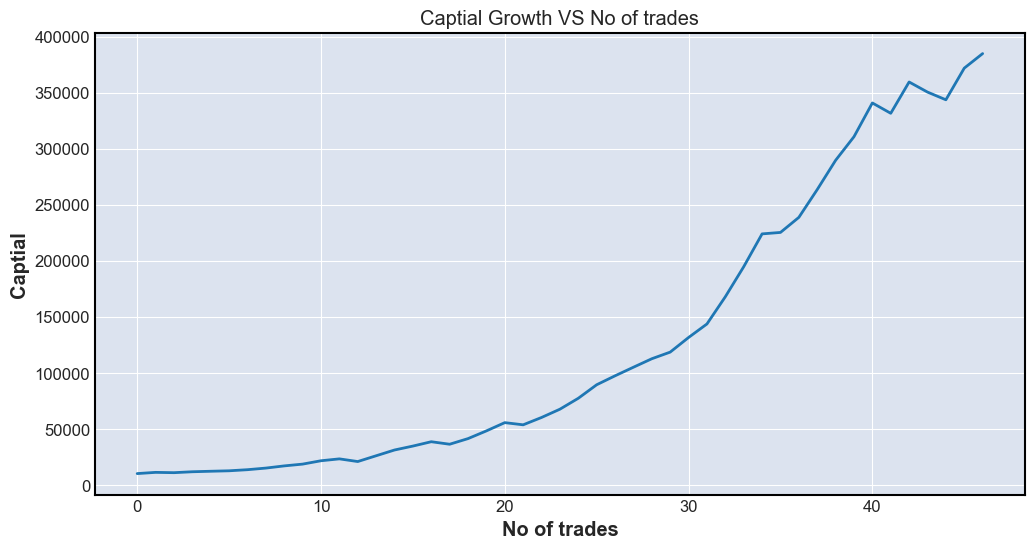

In [6]:
initial_capital=10000
capital=initial_capital
capital_data=[initial_capital]
capital_returns=[0]
for i in range(len(stock_returns["trade"])):
    returns_trade=int(capital/stock_returns["entry"].iloc[i])*stock_returns["profits"].iloc[i]
    returns_trade_percentage=returns_trade*100/capital
    capital=capital+returns_trade
    capital_data.append(capital)
    capital_returns.append(returns_trade_percentage)
stock_returns["portfolio"]=capital_data[1::]
plt.figure(figsize=(12,6))
plt.plot([i for i in range(len(capital_data))], capital_data) 
plt.title("Captial Growth VS No of trades")
plt.xlabel("No of trades")
plt.ylabel("Captial")
plt.show()

In [7]:
import statistics
print("Time period = {:.0f} years".format(days/365))
# 1. sharp Ratio 
risk_free_rate = 4  # Replace this with the actual risk-free rate in %
no_of_trades=len(stock_returns)
excess_returns =[x-(risk_free_rate*(days/365)/no_of_trades) for x in capital_returns]          # Calculate excess returns
sharpe_ratio = statistics.mean(excess_returns) / statistics.stdev(excess_returns)         # Calculate the Sharpe Ratio
print("Sharpe Ratio:", sharpe_ratio)

# 2. annualized return
holding_period_years = days/365 # Change this to the actual holding period
initial=capital_data[0]
final=capital_data[-1]
annualized_return = ((final/initial) ** (1 / holding_period_years)) - 1         # Calculate the annualized return
annualized_return_percentage = annualized_return * 100              # Convert the annualized return to a percentage
print("Annualized return = {:.2f} %".format(annualized_return_percentage))

# 3. benchmark return
# total_returns=((capital_data[-1]/capital_data[0])-1)*100
# print("Total returns = {:.2f} %".format(total_returns))
benchmark_initial=stock_data["Open"].iloc[0]
benchmark_final=stock_data["Close"].iloc[-1]
benchmark_return_percentage = ((benchmark_final / benchmark_initial) - 1) * 100/(days/365)
print("Benchmark return = {:.2f} %".format(benchmark_return_percentage))

# 4. the number of executed trades
print("No of trades =",no_of_trades)

# 5. maximum drawdown
equity_curve=[]
sum_profits=0
for i in range(len(stock_returns)):
    sum_profits += stock_returns["profits"].iloc[i]
    equity_curve.append(sum_profits)

# Calculate drawdown
drawdown = []
peak_value = equity_curve[0]
for equity_value in equity_curve:
    if equity_value > peak_value:
        peak_value = equity_value
    drawdown.append(equity_value - peak_value)
max_drawdown = min(drawdown)
print("Maximum drawdown =",max_drawdown)

# 6. win ratio
losses = stock_returns["profits"][stock_returns["profits"] < 0].count()
win_ratio = (no_of_trades - losses) / no_of_trades
print("win Ratio =",win_ratio)

# 7. largest loss-making trade
largest_loss=stock_returns["profits"].min()
print("Largest Loss =",largest_loss)

# 8. largest profit-making trade
largest_win=stock_returns["profits"].max()
print("Largest win =",largest_win)



Time period = 5 years
Sharpe Ratio: 1.101176147945944
Annualized return = 107.52 %
Benchmark return = 11.45 %
No of trades = 46
Maximum drawdown = -44.29725268147013
win Ratio = 0.8478260869565217
Largest Loss = -44.29725268147013
Largest win = 136.54998779296875


In [8]:
# excel_file = 'Nadaraya Watson.xlsx'
# stock_returns.to_excel(excel_file, index=False)

csv_file="Finance project submission final.csv"
stock_returns.to_csv(csv_file,index=False)